In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
from tensorflow.keras.utils import to_categorical
from keras import metrics as metrics

import random
import sys
import time

import pandas as pd
import numpy as np

import random
import matplotlib.pyplot as plt
import itertools
import glob
import math
tf.keras.backend.set_floatx('float64')

Using TensorFlow backend.


In [2]:
path = r'/home/giang/Lab/Code/Testsets' # use your path
classes = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df, x_np, y_np = {}, {}, {}
x_np_all, y_np_all = np.empty((0, 504)), np.empty((0,1))

for i, cls in classes.items():
    print(i, cls)
    all_files = glob.glob(path + "/" + cls + "/*.csv")
    df[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_np[i] = np.transpose(np.array(df[i]))
    print(x_np[i].shape)
   
    y_np[i] = np.ones((len(x_np[i]),1)) * i # Target label
    print(y_np[i].shape)
    
    x_np_all = np.concatenate((x_np_all, x_np[i]), axis=0)
    y_np_all = np.concatenate((y_np_all, y_np[i]), axis=0)
    
print(x_np_all.shape, y_np_all.shape)

0 P0-W0
(861, 504)
(861, 1)
1 P1-W1
(743, 504)
(743, 1)
2 P9-W7
(819, 504)
(819, 1)
3 P14-W0
(824, 504)
(824, 1)
(3247, 504) (3247, 1)


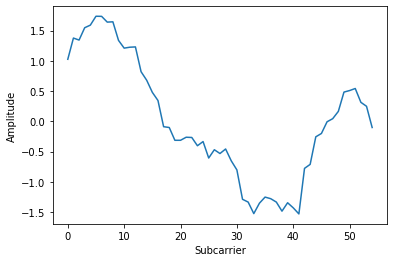

In [3]:
plt.plot(x_np[0][0][0:55])
#plt.plot(x_np[1])
#plt.plot(x_np[2])
#plt.plot(x_np[3])
plt.xlabel("Subcarrier")
plt.ylabel("Amplitude")
plt.show()

In [4]:
data_label = np.empty((len(x_np_all),0))
data_label = np.concatenate((x_np_all,y_np_all),axis=1)
print(data_label.shape)
np.random.shuffle(data_label)
task_data,task_label = np.split(data_label,[-1],axis=1)
print(task_data.shape)
print(task_label.shape)

(3247, 505)
(3247, 504)
(3247, 1)


In [5]:
class MLPModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(50, input_shape=(504,))
        self.hidden2 = keras.layers.Dense(30)
        self.hidden3 = keras.layers.Dense(30)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = keras.activations.relu(self.hidden3(x))
        x = self.out(x)
        return x

In [6]:
def loss_function(y, pred_y):
    return keras_backend.mean(keras.losses.mean_squared_error(y,pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, logits = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss, logits


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss, logits = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return logits, loss

def accuracy_function(y, pred_y):
    return metrics.accuracy(y, pred_y)


In [ ]:
def train_model(model,data,label, epochs=1, lr=0.001, log_steps=1):
    model = model
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    losses = []
    accuracies = []
    for epoch in range(epochs):
        epoch_totalloss = 0
        epoch_totalaccuracy = 0
        start = time.time()
        for i in range(len(data)):
            task_totalloss = 0
            task_totalaccuracy = 0
            for k in range(len(classes)):              
                x = data[i].reshape(1,-1)
                y = label[i]
                logits, task_currloss = train_batch(x, y, model, optimizer)
                task_totalloss += task_currloss
                task_loss = task_totalloss / (k + 1.0)
                roundlogits = np.ceil(logits)
                task_curraccuracy = accuracy_function(y, roundlogits)
                task_totalaccuracy += task_curraccuracy
                task_accuracy = task_totalaccuracy / (k + 1.0)
            epoch_totalaccuracy += task_accuracy
            epoch_totalloss += task_loss
        epoch_loss = epoch_totalloss/(i+1)
        epoch_accuracy = epoch_totalaccuracy/(i+1)
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
            
        if epoch % log_steps == 0 and epoch > 0:
            print('Epoch {}: loss = {}, train accuracy = {}, Time to run {} epoch = {:.2f} seconds'.format(
                    epoch, epoch_loss, epoch_accuracy, log_steps, time.time() - start))
            start = time.time()
    figure(figsize=(10,10))
    plt.plot(losses)
    plt.title('Loss Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    figure(figsize=(10,10))
    plt.plot(accuracies)
    plt.title('Accuracy Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    return model,losses

In [9]:
model = MLPModel()
trained, loss = train_model(model,task_data,task_label,5)

KeyboardInterrupt: 

In [7]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = MLPModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


In [8]:
def train_maml(model,dataset, label, epochs, lr_inner=0.01, batch_size=1, log_steps=1):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    losses = []
    accuracy = []
    for epoch in range(epochs):
        #epoch_accuracy = tf.keras.metrics.Accuracy()
        total_loss = 0
        total_acc = 0
        start = time.time()
        # Step 3 and 4
        for i in range(len(dataset)):  
            x = dataset[i].reshape(1,-1)
            y = label[i]
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            round_logits = math.ceil(logits)
            task_acc = accuracy_function(y,round_logits)
            # Logs
            total_loss += test_loss
            total_acc += task_acc
        epoch_loss = total_loss / (i+1.0)
        epoch_acc = total_acc / (i+1.0)
        losses.append(epoch_loss)
        accuracy.append(epoch_acc)
            
        if epoch % log_steps == 0:
            print('Epoch {}: Loss = {}, Train Accuracy = {}, Time to run {} Epoch = {}'.format(epoch+1, epoch_loss, epoch_acc, log_steps, time.time() - start))
            start = time.time()
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.show()
    plt.figure()
    plt.plot(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    return model, losses, accuracy

Epoch 1: Loss = 0.014464331154384506, Train Accuracy = [0.47736372], Time to run 1 Epoch = 469.7796576023102
Epoch 2: Loss = 0.002728958587957903, Train Accuracy = [0.48598706], Time to run 1 Epoch = 468.2381594181061
Epoch 3: Loss = 0.0006527693179194745, Train Accuracy = [0.43855867], Time to run 1 Epoch = 469.2459042072296
Epoch 4: Loss = 0.0013464071527759306, Train Accuracy = [0.48413921], Time to run 1 Epoch = 469.1379323005676
Epoch 5: Loss = 0.00036278971000253016, Train Accuracy = [0.52202033], Time to run 1 Epoch = 468.33169984817505
Epoch 6: Loss = 0.0006265514803691597, Train Accuracy = [0.49029874], Time to run 1 Epoch = 467.6510179042816
Epoch 7: Loss = 0.00023043537691195808, Train Accuracy = [0.4921466], Time to run 1 Epoch = 469.4685871601105
Epoch 8: Loss = 0.00041054608630866336, Train Accuracy = [0.48506314], Time to run 1 Epoch = 467.98532485961914
Epoch 9: Loss = 8.909259223027653e-05, Train Accuracy = [0.49923006], Time to run 1 Epoch = 467.8618814945221
Epoch 10

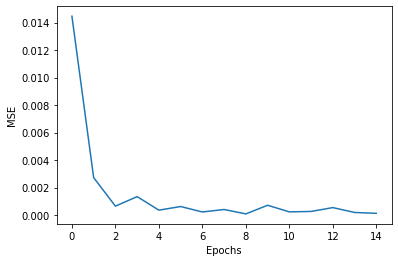

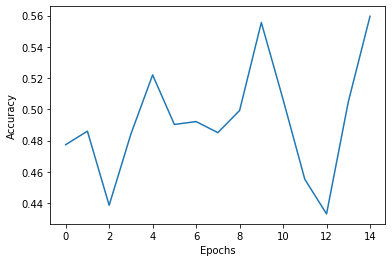

In [9]:
model2 = MLPModel()
maml, loss, accuracy = train_maml(model2,task_data,task_label,15)

In [10]:
testpath = r'/home/giang/Lab/Code/Trainsets' # use your path
testclasses = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df_test, x_np_test, y_np_test = {}, {}, {}
x_np_all_test, y_np_all_test = np.empty((0, 504)), np.empty((0,1))

for i, cls in classes.items():
    print(i, cls)
    all_files = glob.glob(testpath + "/" + cls + "/*.csv")
    df_test[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_np_test[i] = np.transpose(np.array(df_test[i]))
    print(x_np_test[i].shape)
   
    y_np_test[i] = np.ones((len(x_np_test[i]),1)) * i # Target label
    print(y_np_test[i].shape)
    
    x_np_all_test = np.concatenate((x_np_all_test, x_np_test[i]), axis=0)
    y_np_all_test = np.concatenate((y_np_all_test, y_np_test[i]), axis=0)
    
print(x_np_all_test.shape, y_np_all_test.shape)

0 P0-W0
(373, 504)
(373, 1)
1 P1-W1
(361, 504)
(361, 1)
2 P9-W7
(476, 504)
(476, 1)
3 P14-W0
(461, 504)
(461, 1)
(1671, 504) (1671, 1)


In [11]:
data_label_test = np.empty((len(x_np_all_test),0))
data_label_test = np.concatenate((x_np_all_test,y_np_all_test),axis=1)
print(data_label_test.shape)
np.random.shuffle(data_label_test)
task_data_test,task_label_test = np.split(data_label_test,[-1],axis=1)
print(task_data_test.shape)
print(task_label_test.shape)

(1671, 505)
(1671, 504)
(1671, 1)


In [14]:
def adaptation(model, optimizer, data_test, label_test, num_steps = 10, log_step =1):
    losses = []
    accuracies = []
    # If 0 in fits we log the loss before any training
        
    task_loss, task_logits = compute_loss(model, data_test.reshape(1,-1), label_test)
    round_logits = math.ceil(task_logits)
    task_acc = accuracy_function(label_test,round_logits)
       
    losses.append(task_loss)
    accuracies.append(task_acc)
        
    for step in range(1, num_steps):
        
        train_batch(data_test.reshape(1,-1), label_test, model, optimizer)
      
        task_loss, task_logits = compute_loss(model, data_test.reshape(1,-1), label_test)
        round_logits = math.ceil(task_logits)
        task_acc = accuracy_function(label_test,round_logits)
            
        if step % log_step == 0:
            losses.append(task_loss)
            accuracies.append(task_acc)
            
    return accuracies, losses


def test(model, data, label, k = 2, num_steps=10, lr=0.01):
   
    x_test = data[k]
    y_test = label[k]
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x_test.reshape(1,-1))
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    accuracies, losses = adaptation(copied_model, optimizer, x_test, y_test, num_steps)
    
    # plot
    plt.figure()
    plt.plot(losses , '--')
    plt.xlabel('Adaptation Steps')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuracies , '--')
    plt.xlabel('Adaptation Steps')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.show()

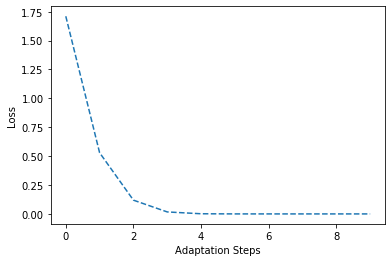

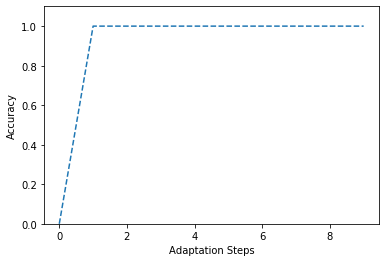

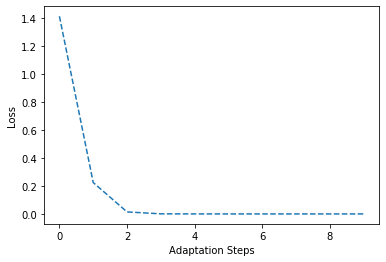

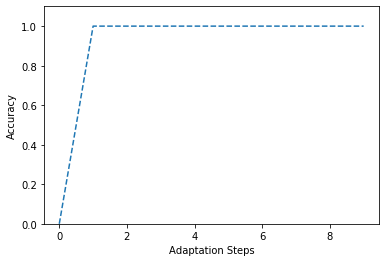

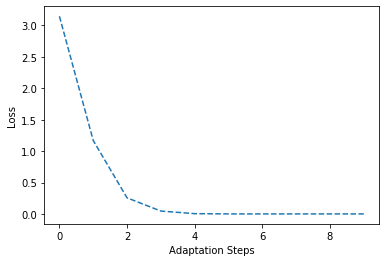

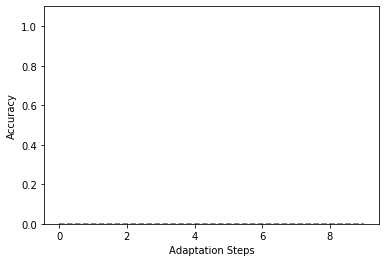

In [24]:
for i in np.random.randint(0, len(task_data_test), size=3):
    test(maml,task_data_test,task_label_test,i)